In [556]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [557]:
test = pd.read_csv('test.csv')
# drive - привод
# condition - состояние авто
# customs - таможня
# ownership - время владения
cols = ['body_type', 'brand', 'color', 'fuel_type', 'model_date', 'name',
        'num_of_doors', 'production_date', 'vehicle_config', 'vehicle_transmission',
               'engine_displacement', 'engine_power', 'description', 'mileage', 'complectation', 'drive',
               'wheel', 'condition', 'owners', 'PTS', 'customs', 'ownership', 'id']
test.columns = cols
test['sample'] = np.ones(len(test))

In [558]:
train = pd.read_excel('bmw_train.xls', usecols='B:Z')
y_train = train['price']
train.drop(['idprice', 'price'], axis=1, inplace=True)

train.columns = cols
train['sample'] = np.zeros(len(train))

In [559]:
# 'no_data' is replaced with np.nan
train.ownership = train.ownership.apply(lambda x: np.nan if x == 'no_data' else x)
train.engine_displacement = train.engine_displacement.apply(lambda x: np.nan if x == 'undefined LTR' else x)
test.engine_displacement = test.engine_displacement.apply(lambda x: np.nan if x == 'undefined LTR' else x)
train.complectation = train.complectation.apply(lambda x: np.nan if x == 'no_data' else x)
train.drive = train.drive.apply(lambda x: np.nan if x == 'no_data' else x)
train.condition = train.condition.apply(lambda x: np.nan if x == 'no_data' else x)
train.owners = train.owners.apply(lambda x: np.nan if x == 'no_data' else x)
train.PTS = train.PTS.apply(lambda x: np.nan if x == 'no_data' else x)
train.customs = train.customs.apply(lambda x: np.nan if x == 'no_data' else x)

# in target variable 'no_data' values were detected, drop these rows
idx = y_train[y_train=='no_data'].index.tolist()
train.drop(index=idx, inplace=True)

In [560]:
data = pd.concat([train, test])

In [561]:
# intrduce lists for numerical, categorical (multiclass) & binary features
num_col = []
cat_col = []
bin_col = []

# EDA

- replace with 'other' class or not (check during stat assessment and model fitting)  
- play with cat and num types in model_date, model_age, production_date, car_age
- text clusterization for description col

In [563]:
# usefull functions
def categorical_data(col, data, rotate_xticks=False):
    plt.figure(figsize=(10, 7))
    data_toplot = data[col].value_counts(normalize=True).sort_index()
    graph = sns.countplot(data[col], order=data_toplot.index)
    ax = graph.axes
    
    if rotate_xticks:
        graph.set_xticklabels(graph.get_xticklabels(), rotation=45)
    
    for bar, value in zip(ax.patches, data_toplot):
        x_text = bar.get_x() + bar.get_width() / 2
        y_text = bar.get_height()
        ax.annotate('{}%'.format(round(100 * value, 2)), (x_text, y_text), ha='center', va='center',
                    fontsize=11, color='black', rotation=0, xytext=(0, 10), textcoords='offset points')
    plt.title('Histogram for ' + col)
    plt.show()
    
def outliers_detection_IQR(col, data):
    
    # detect outliers in data[col]
    
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    left = perc25 - 1.5 * IQR
    right = perc75 + 1.5 * IQR
    print(col+' feature')
    print('min: {0}, max: {1}'.format(data[col].min(), data[col].max()))
    print('outlier boundaries: [{0}, {1}]'.format(left, right))
    if len(data[~data[col].between(left, right)]) > 0:
        print('ratio of outliers: {}'.format(len(data[(~data[col].between(left, right))&(~data[col].isna())])/len(data)))

In EDA section I will almost concentrate on train dataset (in features' histograms and statistical tests) to avoid data leakage.

### How many nans we have

In [564]:
nulls_df = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1)
nulls_df.columns = ['train_data', 'test_data']
nulls_df

,train_data,test_data
body_type,0,0
brand,0,0
color,0,0
fuel_type,0,0
model_date,0,0
name,0,0
num_of_doors,0,0
production_date,0,0
vehicle_config,0,0
vehicle_transmission,0,0


There is no info about duration of ownership (the whole col 'ownership' is empty) in train data. In test data 54 % of 'ownership' is nan.

### 1. 'body_type'
**image**

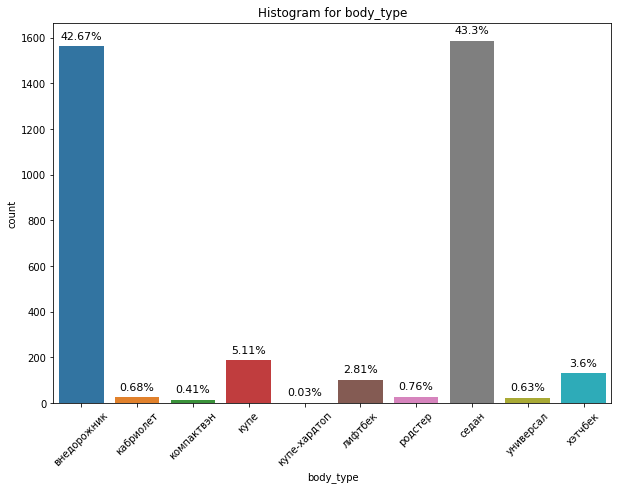

In [565]:
categorical_data('body_type', train, rotate_xticks=True)

The most popular body types are truck (внедорожник) and sedan (седан), they take up >85% of the data in total. **Maybe it makes sense to replace everything, which frequency is less than 0.8% (кабриолет, компактвэн, купе-хардтоп, родстер, универсал), with 'other' category.**

In [566]:
cat_col.append('body_type')

### 2. 'brand'

In [567]:
train.brand.value_counts()

BMW    3663
Name: brand, dtype: int64

In [568]:
test.brand.value_counts()

BMW    3837
Name: brand, dtype: int64

Train dataset consists only of BMW cars. Here I take a look to test data and it have only BMW models too. It's a good news for competition, but the bad one if we want real-life model. If we want our model to predict price correctly for any car brand, we most likely need to include other brands to train dataset.
**In this train dataset I will drop brand column.**

### 3. 'color'

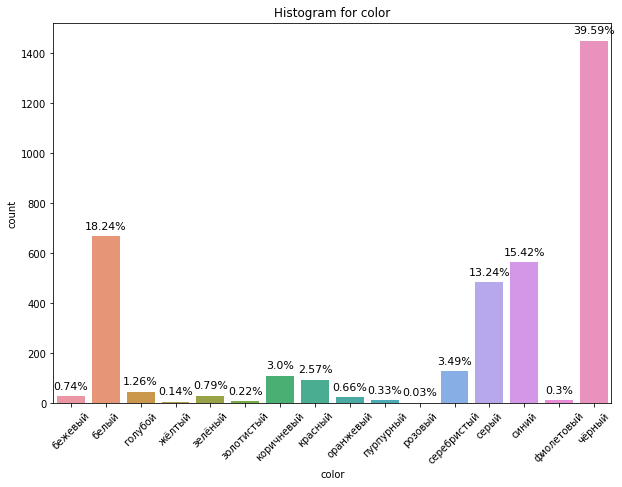

In [569]:
categorical_data('color', train, rotate_xticks=True)

Let's **replace least frequent colors (бежевый, жёлтый, зелёный, золотистый, оранжевый, пурпурный, розовый, фиолетовый) with 'other'** as I did earlier.

In [570]:
cat_col.append('color')

### 4. 'fuel_type'

Train data


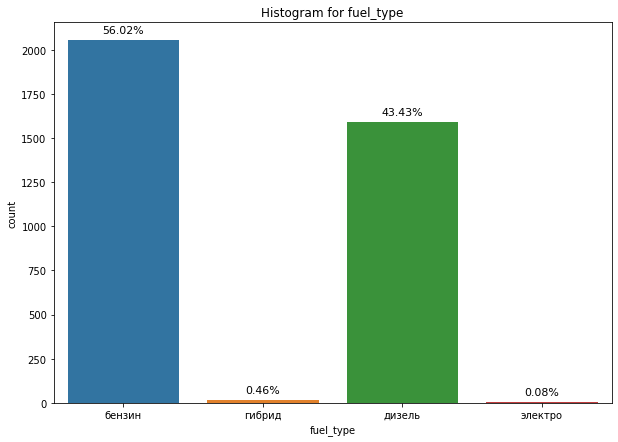

In [571]:
print('Train data')
categorical_data('fuel_type', train)

Test data


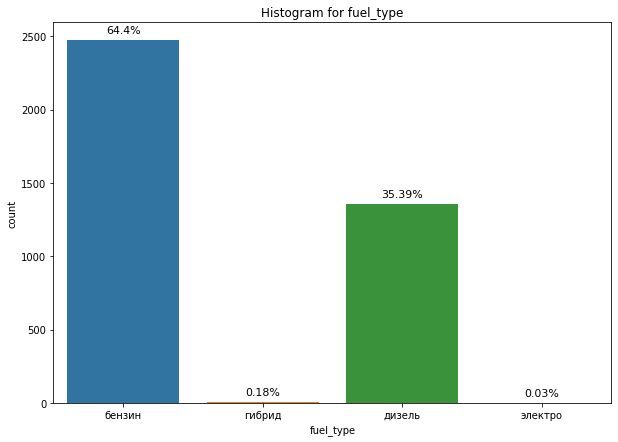

In [572]:
print('Test data')
categorical_data('fuel_type', test)

Maybe it makes sense **to drop or modify in some way 'electro' and 'hybrid' type** because it is very unpopular car type (on Russian market for sure), which can confuse model.

In [573]:
cat_col.append('fuel_type')

### 5. model_date
Date when a model was released.

Text(0, 0.5, 'Number of cars')

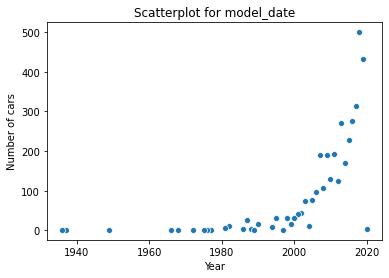

In [574]:
chart = sns.scatterplot(x=train.model_date.value_counts().index.tolist(),
               y=train.model_date.value_counts().values.tolist())

chart.set_title('Scatterplot for model_date')
chart.set_xlabel('Year')
chart.set_ylabel('Number of cars')

**Feature engeneering: car age** (how many years ago a car was released).

Text(0, 0.5, 'Number of cars')

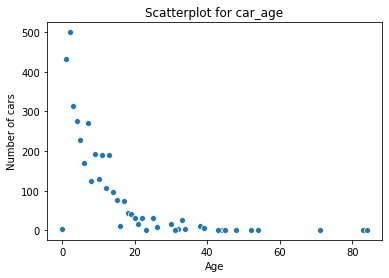

In [575]:
# how old is the model
model_age = 2020 - train.model_date


chart = sns.scatterplot(x=model_age.value_counts().index.tolist(),
                        y=model_age.value_counts().values.tolist())
chart.set_title('Scatterplot for car_age')
chart.set_xlabel('Age')
chart.set_ylabel('Number of cars')

In [576]:
data['model_age'] = 2020 - data.model_date

**There are two ways**: 1) consider model_date as a categorical variable and try 'other' class for cars, say, released before 1960-70; 2) consider model_date as a numerical variable. Model_age also can be considered as categorical variable (with classe like >10, >20, >30... years).

In [577]:
cat_col.append('model_date')
num_col.append('model_age')

### 6. 'name'
Official name of the car model.

In [578]:
print('Number of unque values in train data: {} out of {} rows'.format(train.name.nunique(), len(train)))

Number of unque values in train data: 483 out of 3663 rows


In [579]:
train.name.value_counts()

BMW X3  III (G01) 20d xDrive                         134
BMW X1  II (F48) Рестайлинг 18d xDrive               112
BMW 5 серия  VII (G30/G31) 520d xDrive                92
BMW 2 серия Gran Coupe F44 218i                       90
BMW X1  II (F48) Рестайлинг 20i xDrive                68
                                                    ... 
BMW 3 серия  V (E90/E91/E92/E93) Рестайлинг 335d       1
BMW 7 серия  V (F01/F02/F04) 750i                      1
BMW 5 серия  VII (G30/G31) Рестайлинг 520d xDrive      1
BMW 3 серия  II (E30) 316 Ecotronic                    1
BMW Z4  III (G29) 30i                                  1
Name: name, Length: 483, dtype: int64

In [580]:
test.name.value_counts()

35i 3.0 AT (306 л.с.) 4WD            193
30d 3.0d AT (249 л.с.) 4WD           148
520i 2.0 AT (184 л.с.)               103
320i xDrive 2.0 AT (184 л.с.) 4WD     92
320i 2.0 AT (184 л.с.)                91
                                    ... 
525xi 3.0 MT (218 л.с.) 4WD            1
535i 3.5 AT (235 л.с.)                 1
525i 2.5 AT (170 л.с.)                 1
318i 1.8 AT (140 л.с.)                 1
740i 3.0 AT (326 л.с.)                 1
Name: name, Length: 384, dtype: int64

**Firstly, data formats in train and test should be agreed. Secondly, the most frequent names could be converted into dummy variables, other could be dropped.**

### 7. 'num_of_doors'

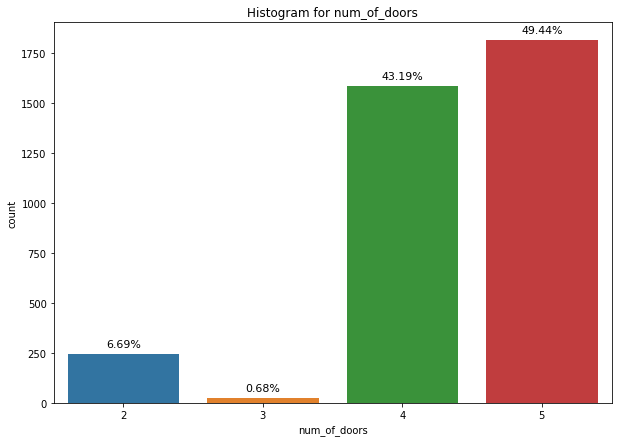

In [581]:
categorical_data('num_of_doors', train)

Ordinary categorical variable with clean data.

In [582]:
cat_col.append('num_of_doors')

### 8. 'production_date'
Date when a car was produced.  
Same research as with 'model_date'...

Text(0, 0.5, 'Number of cars')

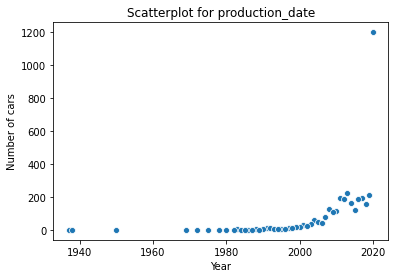

In [583]:
chart = sns.scatterplot(x=train.production_date.value_counts().index.tolist(),
               y=train.production_date.value_counts().values.tolist())
chart.set_title('Scatterplot for production_date')
chart.set_xlabel('Year')
chart.set_ylabel('Number of cars')

Pay attention that production_date graph shows less tendency to rise than model_date.

**Feature engeneering: car age.**

In [584]:
data['car_age'] = 2020 - data.production_date

In [585]:
cat_col.append('production_date')
num_col.append('car_age')

### 9. 'vehicle_config'

In [586]:
train.vehicle_config.value_counts()

SEDAN AUTOMATIC 2.0              755
ALLROAD_5_DOORS AUTOMATIC 3.0    694
ALLROAD_5_DOORS AUTOMATIC 2.0    665
SEDAN AUTOMATIC 3.0              370
ALLROAD_5_DOORS AUTOMATIC 4.4    131
                                ... 
COUPE MECHANICAL 3.4               1
SEDAN MECHANICAL 2.8               1
WAGON_5_DOORS AUTOMATIC 2.2        1
COUPE AUTOMATIC 1.6                1
WAGON_5_DOORS AUTOMATIC 2.9        1
Name: vehicle_config, Length: 117, dtype: int64

In [587]:
test.vehicle_config.value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0      850
SEDAN AUTOMATIC 2.0                764
ALLROAD_5_DOORS AUTOMATIC 2.0      534
SEDAN AUTOMATIC 3.0                359
SEDAN AUTOMATIC 2.5                155
                                  ... 
WAGON_5_DOORS AUTOMATIC 2.8          1
SEDAN ROBOT 5.0                      1
COMPACTVAN AUTOMATIC 1.5             1
COUPE MECHANICAL 1.8                 1
HATCHBACK_3_DOORS AUTOMATIC 2.5      1
Name: vehicle_config, Length: 99, dtype: int64

**Try to convert into dummy the most frequent values.**

In [588]:
cat_col.append('vehicle_cofig')

### 10. 'vehicle_transmission'

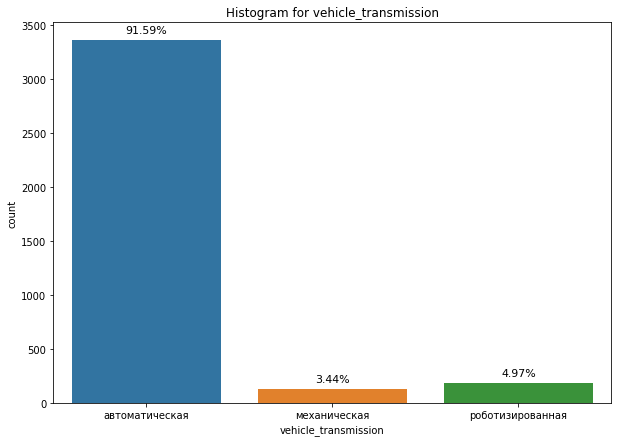

In [591]:
categorical_data('vehicle_transmission', train)

Ordinary categorical variable with clean but imbalanced data. **Try to merge manual (механическая) and robotic (роботизированная) into one class.**

In [592]:
cat_col.append('vehicle_transmission')

### 11. 'engine_displacement'

In [593]:
print('Ratio of nan in train: {}'.format(train.engine_displacement.isnull().sum()/len(train)))
print('Ratio of nan in test: {}'.format(test.engine_displacement.isnull().sum()/len(test)))

Ratio of nan in train: 0.000819000819000819
Ratio of nan in test: 0.00026062027625749283


In [594]:
train.engine_displacement

0       3.0 LTR
1       2.0 LTR
2       3.0 LTR
3       2.0 LTR
4       4.4 LTR
         ...   
3679    3.0 LTR
3680    2.0 LTR
3681    3.0 LTR
3682    2.0 LTR
3683    3.0 LTR
Name: engine_displacement, Length: 3663, dtype: object

The ratio of nan is very small, so we can **fill it with the mean or median value**. There is a tempation to consider this variable as numerical. **Let's do small manipulation for that.**

In [595]:
train.engine_displacement = train.engine_displacement.apply(lambda x: str(x).replace('LTR', '')).astype(float)
data.engine_displacement = data.engine_displacement.apply(lambda x: str(x).replace('LTR', '')).astype(float)

In [596]:
num_col.append('engine_displacement')

### 12. 'engine_power'

In [597]:
train.engine_power.value_counts()

190 N12    481
184 N12    475
249 N12    410
150 N12    236
306 N12    166
          ... 
75 N12       1
188 N12      1
329 N12      1
238 N12      1
125 N12      1
Name: engine_power, Length: 81, dtype: int64

N12 is metric horsepower (unit of measurement).  
1 metric horsepower = 0.9863 horsepower  
So here I definetely deal with numerical variable. **Some magic and I will go further.**

In [598]:
# here is magic
train.engine_power = train.engine_power.apply(lambda x: str(x).replace('N12', '')).astype(float)
data.engine_power = data.engine_power.apply(lambda x: str(x).replace('N12', '')).astype(float)

In [599]:
num_col.append('engine_power')

### 13. description

In [600]:
train.description.iloc[0]

'BMW X6 35i Рестайлинг \n   Автомобиль в идеальном внешнем и техническом состоянии , куплен у официального дилера БМВ Русланд Трейдинг в июне 2014 года , обслуживание автомобиль проходил в BMW Сервисе Сергея Смирнова . \n   Юридически автомобиль полностью чист . Полный комплект ключей (2 шт) и документов (ПТС и СТС). Готов , при Вашем желании , присутствовать при переоформлении автомобиля в ГИБДД .\n    Мотор , коробка , ходовая часть , трансмиссия , электрика абсолютно без нареканий и вложений . Всё работает штатно . Никаких подтёков и запотеваний .\n    Родной , Оригинальный , Настоящий Пробег .\n    Салон чистый и ухоженный . Не просиженный , не продавленный . В семье никто из нас не курит соответственно в машине тоже . \n     Автомобиль не участвовал в ДТП . Любые проверки толщиномерами , жестянщиками и малярами только приветствуются . Два косметических окраса (капот , заднее левое крыло). Пластиковые элементы (бампера , передние крылья ) освежались . \n    Комплектация :\n- Led оп

Here is whole text in each row. At first glance I have three ideas. (1) Implement text clusterization. It would be time consuming and I'm not sure the effort is worth it. (2) Convert top popular words into dummy variables. The easiest way to safe some information. (3) Just drop.

### 14. 'mileage'

Text(0.5, 1.0, 'Price (target) dependence on mileage')

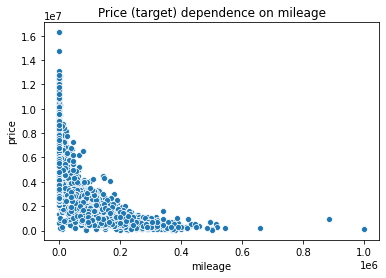

In [601]:
chart = sns.scatterplot(x=train.mileage, y=y_train)
chart.set_title('Price (target) dependence on mileage')

Cars with zero mileage have the biggest price range. Price difference then decreases with the rise of mileage.

Text(0, 0.5, 'Count')

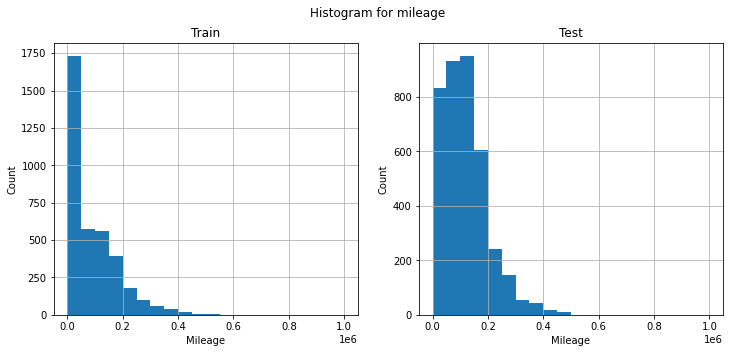

In [602]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
train.mileage.hist(bins=20, ax=axes[0])
test.mileage.hist(bins=20, ax=axes[1])
plt.suptitle('Histogram for mileage')
axes[0].set_title('Train')
axes[1].set_title('Test')

axes[0].set_xlabel('Mileage')
axes[0].set_ylabel('Count')

axes[1].set_xlabel('Mileage')
axes[1].set_ylabel('Count')

Histograms for train and test mileage are significantly different. **It would be better to add some samples with mileage from 10K to 200K km to train dataset.**

The most part of train dataset are the cars with mileage <200K km. What about outliers?

In [603]:
# by IQR
outliers_detection_IQR('mileage', train)

mileage feature
min: 0, max: 1000000
outlier boundaries: [-205373.25, 342288.75]
ratio of outliers: 0.01911001911001911


**Try to replace outliers in some way.**

In [604]:
num_col.append('mileage')

### 15. 'complectation'

In [605]:
print('Ratio of nan in train: {}'.format(round(train.complectation.isnull().sum()/len(train), 2)))

Ratio of nan in train: 0.68


In [606]:
train.complectation, test.complectation

(0                       NaN
 1                       NaN
 2                       NaN
 3                       NaN
 4                       NaN
                ...         
 3679                    NaN
 3680      XDrive18d M Sport
 3681                    NaN
 3682    XDrive20i Advantage
 3683                    NaN
 Name: complectation, Length: 3663, dtype: object,
 0       ['[{"name":"Безопасность","values":["Антипробу...
 1       ['[{"name":"Комфорт","values":["Круиз-контроль...
 2       ['[{"name":"Комфорт","values":["Круиз-контроль...
 3       ['[{"name":"Комфорт","values":["Круиз-контроль...
 4       ['[{"name":"Комфорт","values":["Круиз-контроль...
                               ...                        
 3832    ['[{"name":"Комфорт","values":["Круиз-контроль...
 3833    ['[{"name":"Комфорт","values":["Круиз-контроль...
 3834    ['[{"name":"Комфорт","values":["Круиз-контроль...
 3835    ['[{"name":"Комфорт","values":["Круиз-контроль...
 3836    ['[{"name":"Комфорт","values":[

Train dataset has too much nan values in this feature. To use it in predictions one should add more data. **And the format of data in train and test should be agreed** (see the difference above). 

### 16. 'drive'

In [607]:
print('Ratio of nan in train: {}'.format(round(train.drive.isnull().sum()/len(train), 2)))

Ratio of nan in train: 0.32


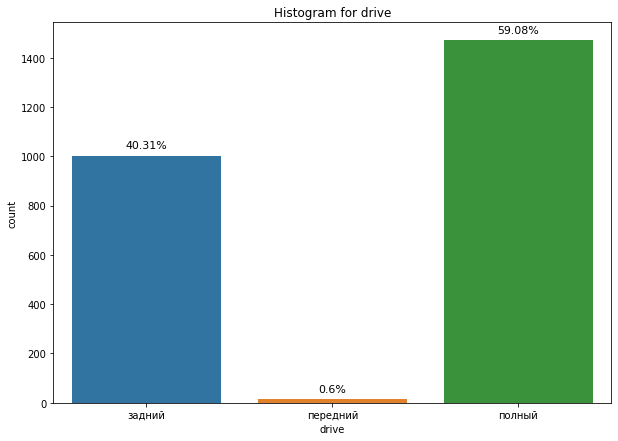

In [608]:
categorical_data('drive', train)

Class 'передний' is only 0.6 % of data and nan values is about 32 %. **I will try to merge them into one class named 'other'.**

In [609]:
cat_col.append('drive')

### 17. 'wheel'

In [610]:
train.wheel.value_counts()

Левый     2487
левый     1175
Правый       1
Name: wheel, dtype: int64

In [611]:
test.wheel.value_counts()

Левый    3837
Name: wheel, dtype: int64

I think it defenitely make sense **to drop this feature from dataset** because it has only one sample of right-hand drive.

In [612]:
data.drop(['wheel'], axis=1, inplace=True)
train.drop(['wheel'], axis=1, inplace=True)
test.drop(['wheel'], axis=1, inplace=True)

### 18. 'condition'

In [613]:
print('Ratio of nan in train: {}'.format(round(train.drive.isnull().sum()/len(train), 2)))

Ratio of nan in train: 0.32


In [614]:
train.condition.value_counts()

Не требует ремонта    2488
Name: condition, dtype: int64

In [615]:
test.condition.value_counts()

Не требует ремонта    3837
Name: condition, dtype: int64

**Remove this feature too.**

In [616]:
data.drop(['condition'], axis=1, inplace=True)
train.drop(['condition'], axis=1, inplace=True)
test.drop(['condition'], axis=1, inplace=True)

### 19. 'owners'

In [617]:
print('Ratio of nan in train: {}'.format(round(train.owners.isnull().sum()/len(train), 2)))

Ratio of nan in train: 0.32


In [618]:
train.owners.value_counts()

3 или более    984
1 владелец     812
2 владельца    692
Name: owners, dtype: int64

In [619]:
test.owners.value_counts()

3 или более    1516
1 владелец     1309
2 владельца    1012
Name: owners, dtype: int64

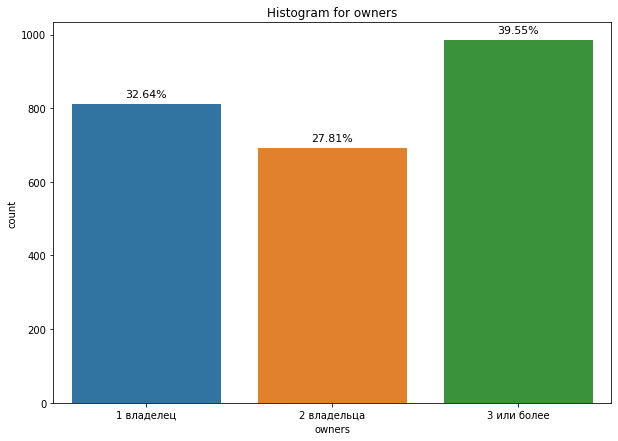

In [620]:
categorical_data('owners', train)

Proportion of nan is big enough, so **I will separate it into 'no_data' class.**

### 20. 'PTS'

In [621]:
print('Ratio of nan in train: {}'.format(round(train.PTS.isnull().sum()/len(train), 2)))

Ratio of nan in train: 0.32


In [622]:
train.PTS.value_counts() / len(train)

Оригинал    0.599782
Дубликат    0.079443
Name: PTS, dtype: float64

In [623]:
test.PTS.value_counts() / len(test)

Оригинал    0.902528
Дубликат    0.097472
Name: PTS, dtype: float64

In train PTS feature has the same class imbalance as in test data.  
Proportion of nan is big enough, so **I will separate it into 'no_data' class.**

### 21. 'customs' 

In [624]:
print('Ratio of nan in train: {}'.format(round(train.customs.isnull().sum()/len(train), 2)))

Ratio of nan in train: 0.32


In [625]:
train.customs.value_counts()

Растаможен    2488
Name: customs, dtype: int64

In [626]:
test.customs.value_counts()

Растаможен    3837
Name: customs, dtype: int64

**Remove this feature too.**

In [627]:
data.drop(['customs'], axis=1, inplace=True)
train.drop(['customs'], axis=1, inplace=True)
test.drop(['customs'], axis=1, inplace=True)

### 22. 'ownership' 

In [628]:
print('Ratio of nan in train: {}'.format(round(train.ownership.isnull().sum()/len(train), 2)))
print('Ratio of nan in test: {}'.format(round(test.ownership.isnull().sum()/len(train), 2)))

Ratio of nan in train: 1.0
Ratio of nan in test: 0.57


In [629]:
test.ownership.value_counts()

1 год и 1 месяц        40
1 год и 4 месяца       39
1 год и 3 месяца       37
1 год и 2 месяца       36
1 год и 8 месяцев      33
                       ..
12 лет и 7 месяцев      1
11 лет и 8 месяцев      1
16 лет и 8 месяцев      1
15 лет и 9 месяцев      1
15 лет и 10 месяцев     1
Name: ownership, Length: 157, dtype: int64

Train dataset has no info about ownership and test dataset has about 60% of nan here. **Two ways: 1) add data to train with info about ownership and separate nan into 'no_data' class, 2) remove this feature.**

### 23. 'id'

In [630]:
print('Length of train\nBefore drop_duplicates:{}'.format(len(train)))
train.drop_duplicates(inplace=True), data.drop_duplicates(inplace=True)
print('After drop_duplicates: {}'.format(len(train)))

Length of train
Before drop_duplicates:3663
After drop_duplicates: 3517


In [631]:
train.id

0       1100270678
1       1099961464
2       1099394642
3       1100342510
4       1100518390
           ...    
3679    1099685866
3680    1100055668
3681    1099914324
3682    1100055574
3683    1096467230
Name: id, Length: 3517, dtype: int64

I think that id feature will then be useless for prediction because it is unique for each sample.